<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/35_4_GAN_MNIST_fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras

In [2]:
from random import randint
import tensorflow as tf
from tensorflow import keras
from keras.datasets import fashion_mnist
from tensorflow.keras import layers

from PIL import Image
import imageio
import cv2
from keras.preprocessing.image import img_to_array

import numpy as np
import os
from keras import preprocessing
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
# обучающие данные
print(train_images.shape)
print(len(train_images))
print(train_images.dtype)

(60000, 28, 28)
60000
uint8


In [5]:
# тестовые данные
print(test_images.shape)
print(len(test_labels))
print(test_labels.dtype)
print(test_labels)

(10000, 28, 28)
10000
uint8
[9 2 1 ... 8 1 5]


In [6]:
# наименования меток
class_names = ['Футболка', "Шорты", "Свитер", "Платье",
              "Плащ", "Сандали", "Рубашка", "Кроссовок", "Сумка",
              "Ботинок"]

Номер метки изображения: 7
Наименование метки изображения: Кроссовок 



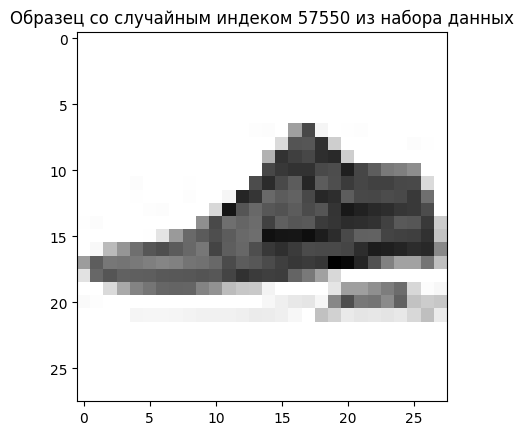

In [7]:
random_number = randint(0, len(train_labels)-1)

digit = train_images[random_number]
fig, ax = plt.subplots(1,1)
print(f'Номер метки изображения: {train_labels[random_number]}')
print(f'Наименование метки изображения: {class_names[train_labels[random_number]]}', '\n')
ax.set_title(f'Образец со случайным индеком {random_number} из набора данных')
ax.imshow(digit, cmap=plt.cm.binary)
plt.show()

In [8]:
# константы
SIZE = 28                   # линейный размер изображений (одно измерение)
INPUT_IMG = (SIZE, SIZE, 1) # размер входного изображений
BATCH_SIZE = 256             # размер пакета для обучения
LATENT_DIM = 100            # размерность латентного пространства
print(INPUT_IMG)

(28, 28, 1)


In [9]:
train_images = train_images.astype('float32')
print(train_images.dtype)

train_images = (train_images - 127.5) / 127.5
X_train = np.array(train_images)

print(X_train.shape)

float32
(60000, 28, 28)


In [10]:
dataset=tf.data.Dataset.from_tensor_slices(train_images).batch(BATCH_SIZE)

In [11]:
def Generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

generator = Generator()
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,254,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 7, 7, 128)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 14, 14, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [12]:
def Discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = Discriminator()
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

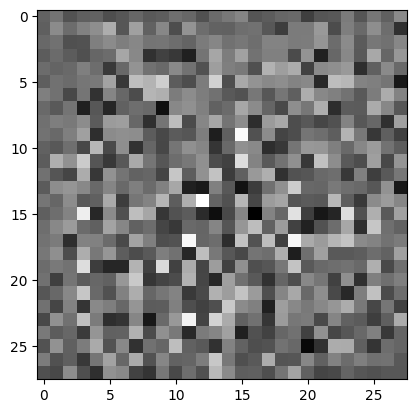

In [13]:
noise = np.random.normal(-1,1,(1,LATENT_DIM))
img = generator(noise)
plt.imshow(img[0,:,:,0], cmap=plt.cm.binary)
plt.show()

In [14]:
optimizer_G = tf.keras.optimizers.RMSprop(learning_rate=.0001)
optimizer_D = tf.keras.optimizers.RMSprop(learning_rate=.0001)

# Этот метод возвращает вспомогательную функцию для вычисления перекрестных потерь энтропии
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [15]:
def discriminator_loss(fake_output, real_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    return fake_loss + real_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

@tf.function
def train_steps(images):
    noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:

        generated_images = generator(noise)
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)
    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)
    optimizer_G.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    optimizer_D.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))
    loss = {'gen_loss':gen_loss,
           'disc_loss': dis_loss}
    return loss

In [16]:
import time
def train(epochs, dataset):
    D_loss=[] # список для сбора значений потерь для дискриминатора
    G_loss=[] # список для сбора значений потерь для генератора
    for epoch in range(epochs):
        start = time.time()
        print("\nЭпоха : {}".format(epoch + 1))
        for images in dataset:
            loss = train_steps(images)
        print(" Время:{}".format(np.round(time.time() - start),2))
        print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen_loss'],loss['disc_loss']))
        D_loss.append(loss['disc_loss'])
        G_loss.append(loss['gen_loss'])
    return (G_loss, D_loss)

In [19]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch}.png')
    plt.show()

In [20]:
G, D = train(100, dataset)


Эпоха : 1
 Время:9.0
Generator Loss: 8.90317153930664 Discriminator Loss: 0.18647734820842743

Эпоха : 2
 Время:9.0
Generator Loss: 7.748330593109131 Discriminator Loss: 0.16651684045791626

Эпоха : 3
 Время:9.0
Generator Loss: 2.9764842987060547 Discriminator Loss: 0.8652750253677368

Эпоха : 4
 Время:9.0
Generator Loss: 1.3856102228164673 Discriminator Loss: 0.7853686809539795

Эпоха : 5
 Время:9.0
Generator Loss: 0.9725889563560486 Discriminator Loss: 1.0678815841674805

Эпоха : 6
 Время:9.0
Generator Loss: 1.2183327674865723 Discriminator Loss: 0.9350950121879578

Эпоха : 7
 Время:10.0
Generator Loss: 1.1988410949707031 Discriminator Loss: 0.8990926742553711

Эпоха : 8
 Время:10.0
Generator Loss: 1.7135541439056396 Discriminator Loss: 0.9891141653060913

Эпоха : 9
 Время:10.0
Generator Loss: 1.4085254669189453 Discriminator Loss: 0.8995652198791504

Эпоха : 10
 Время:10.0
Generator Loss: 1.0906800031661987 Discriminator Loss: 0.9206098318099976

Эпоха : 11
 Время:10.0
Generator Lo

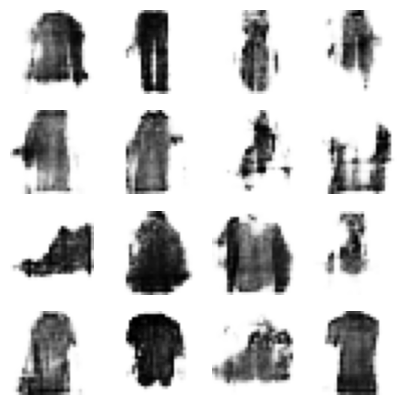

In [22]:
def plot_generated_images(square = 4):
    plt.figure(figsize = (5,5))
    for i in range(square * square):
        plt.subplot(square, square, i+1)
        noise = np.random.normal(0,1,(1,LATENT_DIM))
        img = generator(noise)
        plt.imshow(np.clip((img[0,...]+1)/2, 0, 1), cmap=plt.cm.binary)
        plt.axis('off')
        plt.grid()

plot_generated_images(4)

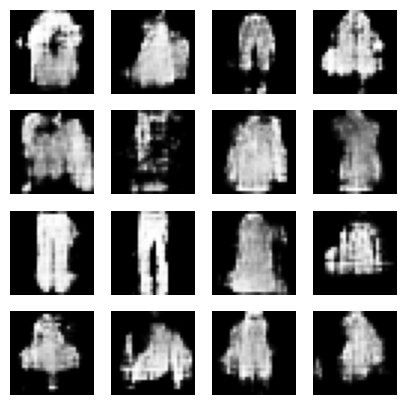

In [23]:
def plot_generated_images(square = 4):
    plt.figure(figsize = (5,5))
    for i in range(square * square):
        plt.subplot(square, square, i+1)
        noise = np.random.normal(0,1,(1,LATENT_DIM))
        img = generator(noise)
        plt.imshow(np.clip((img[0,...]+1)/2, 0, 1), cmap='gray')
        plt.axis('off')
        plt.grid()

plot_generated_images(4)

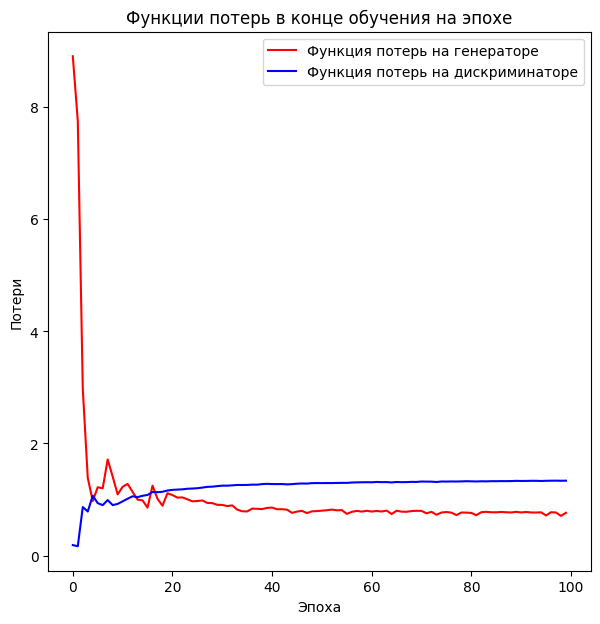

In [24]:
def loss_plot(G, D):
    plt.figure(figsize=(7,7))
    plt.plot(G,color='red',label='Функция потерь на генераторе')
    plt.plot(D,color='blue',label='Функция потерь на дискриминаторе')
    plt.legend()
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.title('Функции потерь в конце обучения на эпохе')
    plt.show()

loss_plot(G, D)

In [25]:
G, D = train(200, dataset)


Эпоха : 1
 Время:10.0
Generator Loss: 0.7018105983734131 Discriminator Loss: 1.3359003067016602

Эпоха : 2
 Время:10.0
Generator Loss: 0.7565353512763977 Discriminator Loss: 1.339461326599121

Эпоха : 3
 Время:10.0
Generator Loss: 0.7609842419624329 Discriminator Loss: 1.3377366065979004

Эпоха : 4
 Время:10.0
Generator Loss: 0.7073665857315063 Discriminator Loss: 1.332168459892273

Эпоха : 5
 Время:10.0
Generator Loss: 0.7128995060920715 Discriminator Loss: 1.3340882062911987

Эпоха : 6
 Время:10.0
Generator Loss: 0.7082053422927856 Discriminator Loss: 1.3306043148040771

Эпоха : 7
 Время:10.0
Generator Loss: 0.7577624320983887 Discriminator Loss: 1.3393467664718628

Эпоха : 8
 Время:10.0
Generator Loss: 0.7617415189743042 Discriminator Loss: 1.3388032913208008

Эпоха : 9
 Время:10.0
Generator Loss: 0.7098734378814697 Discriminator Loss: 1.3348629474639893

Эпоха : 10
 Время:10.0
Generator Loss: 0.7078782320022583 Discriminator Loss: 1.335397720336914

Эпоха : 11
 Время:10.0
Generato

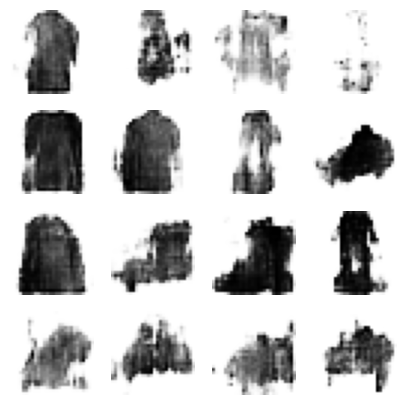

In [26]:
def plot_generated_images(square = 4):
    plt.figure(figsize = (5,5))
    for i in range(square * square):
        plt.subplot(square, square, i+1)
        noise = np.random.normal(0,1,(1,LATENT_DIM))
        img = generator(noise)
        plt.imshow(np.clip((img[0,...]+1)/2, 0, 1), cmap=plt.cm.binary)
        plt.axis('off')
        plt.grid()

plot_generated_images(4)

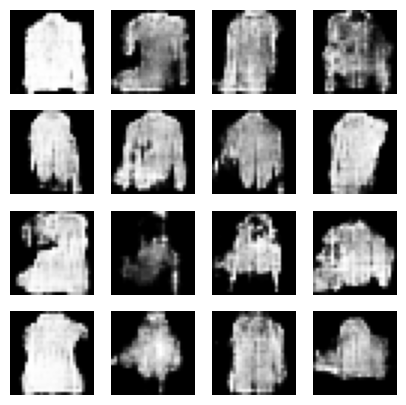

In [27]:
def plot_generated_images(square = 4):
    plt.figure(figsize = (5,5))
    for i in range(square * square):
        plt.subplot(square, square, i+1)
        noise = np.random.normal(0,1,(1,LATENT_DIM))
        img = generator(noise)
        plt.imshow(np.clip((img[0,...]+1)/2, 0, 1), cmap='gray')
        plt.axis('off')
        plt.grid()

plot_generated_images(4)

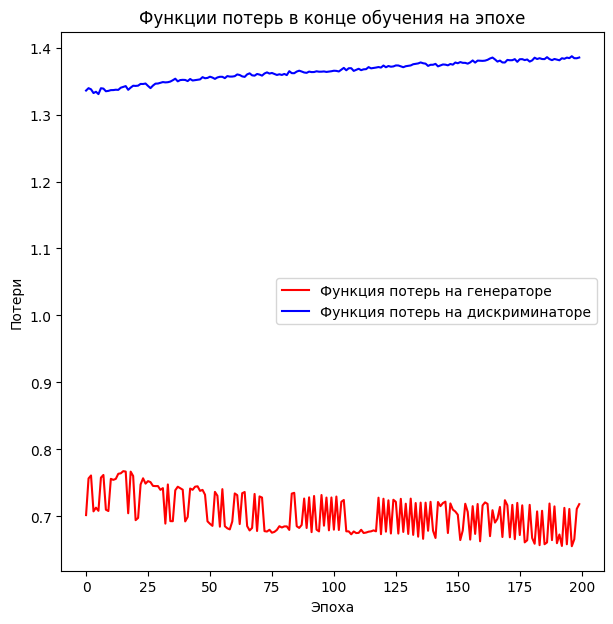

In [28]:
def loss_plot(G, D):
    plt.figure(figsize=(7,7))
    plt.plot(G,color='red',label='Функция потерь на генераторе')
    plt.plot(D,color='blue',label='Функция потерь на дискриминаторе')
    plt.legend()
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.title('Функции потерь в конце обучения на эпохе')
    plt.show()

loss_plot(G, D)